In [1]:
import json
import tkp.db
import tkp.config
import logging
import csv
import datetime
import os
import glob

import numpy as np
import pandas as pd
import scipy as sp
import healpy as hp
from scipy.interpolate import griddata

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_sky,  AltAz, EarthLocation
from astropy.io import fits
from astropy.wcs import WCS

import matplotlib.pyplot as plt

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
def distSquared(p0, p1):
    '''
    Calculate the distance between point p0, [x,y], and a list of points p1, [[x0..xn],[y0..yn]]. 
    '''
    distance  = np.sqrt((p0[0] - p1[0,:])**2 + (p0[1] - p1[1,:])**2)
    if np.min(distance) < 0.5:
        return np.where(distance == np.min(distance))[0]
    else:
        return None

def pol2cart(rho, phi):
    """
    Polar to Cartesian coordinate conversion, for distance measure around celestial pole.
    """
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def run_query(transients_query, dbname, dataset_id, engine, host, port, user, pword):
    tkp.db.Database(
        database=dbname, user=user, password=pword,
        engine=engine, host=host, port=port
    )

    cursor = tkp.db.execute(transients_query, (dataset_id,))
    transients = tkp.db.generic.get_db_rows_as_dicts(cursor)
    return transients

def compare_flux(sr, catalog_ras, catalog_decs, catalog_fluxs, catalog_flux_errs):
    '''
    Compares the two catalogues, matching sources, and outputs the results of linear fit to the fluxes. 
    '''
    x = []
    y = []

    w = []
    sr_indexes = []
    cat_indexes = []


    for i in range(len(sr)):

        sr_x, sr_y = pol2cart(np.abs(90-sr.iloc[i].decl),
                np.deg2rad(sr.iloc[i].ra))

        cat_x, cat_y = pol2cart(np.abs(90-catalog_decs),
                np.deg2rad(catalog_ras))

        index = distSquared((sr_x,sr_y),
                   np.array([cat_x, cat_y]))

        if type(index) == np.ndarray:
            flux = catalog_fluxs[index]
            flux_err = catalog_flux_errs[index]

            cat_indexes.append(index)
            sr_indexes.append(i)
            y.append(float(sr.iloc[i].f_int))
            x.append(float(flux))
            w.append(float(sr.iloc[i].f_int_err))
        else:
            continue

    if len(x) > 2:
        w = np.array(w,dtype=float)
        fit = np.polyfit(x,y,1,w=1./w)
    else:
        fit = [1e9,1e9]

    return fit[0], fit[1], x, y, cat_indexes


In [3]:
engine = 'postgresql'
host = 'ads001'
port = 5432
user = 'mkuiack'
password = 'Morecomplicatedpass1234'

query_loglevel = logging.WARNING 

In [9]:
dbname = "ASr_201702250130"
dataset = 1 #survey_stats[survey_stats.obs == dbname].dataset.values[0]

print "database name: ",  dbname
logging.getLogger('sqlalchemy.engine').setLevel(query_loglevel)


tot_df = pd.DataFrame({"ra":[],"decl":[],"runcat":[],"f_avg":[],"f_std":[], "frame":[]})

n=0

times = pd.date_range(start='2017-02-25 01:30:00', end="2017-02-25 05:00:00",  freq="120s")

for i in range(len(times)-1) :

    db = tkp.db.Database(engine=engine, host=host, port=port,
                         user=user, password=password, database=dbname)

    db.connect()
    session = db.Session()


    print times[i], times[i+1]

    transients_query = '''SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '%s' AND '%s'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;'''% (times[i], times[i+1])
    print transients_query
    light_curves = pd.DataFrame(run_query(transients_query, dbname, dataset, engine, host, port, user, password))

    # AS_databases = [x for x in databases.datname if (x[:3] == "ASf" or x[:3] == "ASr")]

    db._configured = False
    del db, session

    lc_index = light_curves.groupby("runcat").size() > 60

    for i in lc_index.index:
        if not lc_index.loc[i]:
            continue

        light_curve = light_curves[light_curves.runcat == i]

        tot_df = tot_df.append({"ra":light_curve.ra.mean(),
                                "decl":light_curve.decl.mean(),
                                "runcat":light_curve.runcat.mean(),
                                "f_avg":light_curve.f_int.mean(),
                                "f_std":light_curve.f_int.std(),
                                "frame":n},
                               ignore_index=True)
    n+=1

tot_df = tot_df.groupby("ra").mean().reset_index()

database name:  ASr_201702250130
2017-02-25 01:30:00 2017-02-25 01:32:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:30:00' AND '2017-02-25 01:32:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:32:00 2017-02-25 01:34:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:32:00' AND '2017-02-25 01:34:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:34:00 2017-02-25 01:36:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:34:00' AND '2017-02-25 01:36:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:36:00 2017-02-25 01:38:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:36:00' AND '2017-02-25 01:38:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:38:00 2017-02-25 01:40:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:38:00' AND '2017-02-25 01:40:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:40:00 2017-02-25 01:42:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:40:00' AND '2017-02-25 01:42:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:42:00 2017-02-25 01:44:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:42:00' AND '2017-02-25 01:44:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:44:00 2017-02-25 01:46:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:44:00' AND '2017-02-25 01:46:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:46:00 2017-02-25 01:48:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:46:00' AND '2017-02-25 01:48:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:48:00 2017-02-25 01:50:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:48:00' AND '2017-02-25 01:50:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:50:00 2017-02-25 01:52:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:50:00' AND '2017-02-25 01:52:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:52:00 2017-02-25 01:54:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:52:00' AND '2017-02-25 01:54:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:54:00 2017-02-25 01:56:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:54:00' AND '2017-02-25 01:56:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:56:00 2017-02-25 01:58:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:56:00' AND '2017-02-25 01:58:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 01:58:00 2017-02-25 02:00:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 01:58:00' AND '2017-02-25 02:00:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:00:00 2017-02-25 02:02:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:00:00' AND '2017-02-25 02:02:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:02:00 2017-02-25 02:04:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:02:00' AND '2017-02-25 02:04:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:04:00 2017-02-25 02:06:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:04:00' AND '2017-02-25 02:06:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:06:00 2017-02-25 02:08:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:06:00' AND '2017-02-25 02:08:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:08:00 2017-02-25 02:10:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:08:00' AND '2017-02-25 02:10:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:10:00 2017-02-25 02:12:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:10:00' AND '2017-02-25 02:12:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:12:00 2017-02-25 02:14:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:12:00' AND '2017-02-25 02:14:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:14:00 2017-02-25 02:16:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:14:00' AND '2017-02-25 02:16:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:16:00 2017-02-25 02:18:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:16:00' AND '2017-02-25 02:18:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:18:00 2017-02-25 02:20:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:18:00' AND '2017-02-25 02:20:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:20:00 2017-02-25 02:22:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:20:00' AND '2017-02-25 02:22:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:22:00 2017-02-25 02:24:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:22:00' AND '2017-02-25 02:24:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:24:00 2017-02-25 02:26:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:24:00' AND '2017-02-25 02:26:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:26:00 2017-02-25 02:28:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:26:00' AND '2017-02-25 02:28:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:28:00 2017-02-25 02:30:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:28:00' AND '2017-02-25 02:30:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:30:00 2017-02-25 02:32:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:30:00' AND '2017-02-25 02:32:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:32:00 2017-02-25 02:34:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:32:00' AND '2017-02-25 02:34:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:34:00 2017-02-25 02:36:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:34:00' AND '2017-02-25 02:36:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:36:00 2017-02-25 02:38:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:36:00' AND '2017-02-25 02:38:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:38:00 2017-02-25 02:40:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:38:00' AND '2017-02-25 02:40:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:40:00 2017-02-25 02:42:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:40:00' AND '2017-02-25 02:42:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:42:00 2017-02-25 02:44:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:42:00' AND '2017-02-25 02:44:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:44:00 2017-02-25 02:46:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:44:00' AND '2017-02-25 02:46:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:46:00 2017-02-25 02:48:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:46:00' AND '2017-02-25 02:48:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:48:00 2017-02-25 02:50:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:48:00' AND '2017-02-25 02:50:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:50:00 2017-02-25 02:52:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:50:00' AND '2017-02-25 02:52:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:52:00 2017-02-25 02:54:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:52:00' AND '2017-02-25 02:54:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:54:00 2017-02-25 02:56:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:54:00' AND '2017-02-25 02:56:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:56:00 2017-02-25 02:58:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:56:00' AND '2017-02-25 02:58:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 02:58:00 2017-02-25 03:00:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 02:58:00' AND '2017-02-25 03:00:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:00:00 2017-02-25 03:02:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:00:00' AND '2017-02-25 03:02:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:02:00 2017-02-25 03:04:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:02:00' AND '2017-02-25 03:04:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:04:00 2017-02-25 03:06:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:04:00' AND '2017-02-25 03:06:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:06:00 2017-02-25 03:08:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:06:00' AND '2017-02-25 03:08:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:08:00 2017-02-25 03:10:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:08:00' AND '2017-02-25 03:10:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:10:00 2017-02-25 03:12:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:10:00' AND '2017-02-25 03:12:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:12:00 2017-02-25 03:14:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:12:00' AND '2017-02-25 03:14:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:14:00 2017-02-25 03:16:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:14:00' AND '2017-02-25 03:16:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:16:00 2017-02-25 03:18:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:16:00' AND '2017-02-25 03:18:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:18:00 2017-02-25 03:20:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:18:00' AND '2017-02-25 03:20:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:20:00 2017-02-25 03:22:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:20:00' AND '2017-02-25 03:22:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:22:00 2017-02-25 03:24:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:22:00' AND '2017-02-25 03:24:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:24:00 2017-02-25 03:26:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:24:00' AND '2017-02-25 03:26:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:26:00 2017-02-25 03:28:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:26:00' AND '2017-02-25 03:28:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:28:00 2017-02-25 03:30:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:28:00' AND '2017-02-25 03:30:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:30:00 2017-02-25 03:32:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:30:00' AND '2017-02-25 03:32:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:32:00 2017-02-25 03:34:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:32:00' AND '2017-02-25 03:34:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:34:00 2017-02-25 03:36:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:34:00' AND '2017-02-25 03:36:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:36:00 2017-02-25 03:38:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:36:00' AND '2017-02-25 03:38:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:38:00 2017-02-25 03:40:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:38:00' AND '2017-02-25 03:40:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:40:00 2017-02-25 03:42:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:40:00' AND '2017-02-25 03:42:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:42:00 2017-02-25 03:44:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:42:00' AND '2017-02-25 03:44:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:44:00 2017-02-25 03:46:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:44:00' AND '2017-02-25 03:46:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:46:00 2017-02-25 03:48:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:46:00' AND '2017-02-25 03:48:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:48:00 2017-02-25 03:50:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:48:00' AND '2017-02-25 03:50:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:50:00 2017-02-25 03:52:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:50:00' AND '2017-02-25 03:52:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:52:00 2017-02-25 03:54:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:52:00' AND '2017-02-25 03:54:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:54:00 2017-02-25 03:56:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:54:00' AND '2017-02-25 03:56:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:56:00 2017-02-25 03:58:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:56:00' AND '2017-02-25 03:58:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 03:58:00 2017-02-25 04:00:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 03:58:00' AND '2017-02-25 04:00:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:00:00 2017-02-25 04:02:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:00:00' AND '2017-02-25 04:02:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:02:00 2017-02-25 04:04:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:02:00' AND '2017-02-25 04:04:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:04:00 2017-02-25 04:06:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:04:00' AND '2017-02-25 04:06:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:06:00 2017-02-25 04:08:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:06:00' AND '2017-02-25 04:08:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:08:00 2017-02-25 04:10:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:08:00' AND '2017-02-25 04:10:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:10:00 2017-02-25 04:12:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:10:00' AND '2017-02-25 04:12:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:12:00 2017-02-25 04:14:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:12:00' AND '2017-02-25 04:14:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:14:00 2017-02-25 04:16:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:14:00' AND '2017-02-25 04:16:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:16:00 2017-02-25 04:18:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:16:00' AND '2017-02-25 04:18:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:18:00 2017-02-25 04:20:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:18:00' AND '2017-02-25 04:20:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:20:00 2017-02-25 04:22:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:20:00' AND '2017-02-25 04:22:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:22:00 2017-02-25 04:24:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:22:00' AND '2017-02-25 04:24:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:24:00 2017-02-25 04:26:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:24:00' AND '2017-02-25 04:26:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:26:00 2017-02-25 04:28:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:26:00' AND '2017-02-25 04:28:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:28:00 2017-02-25 04:30:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:28:00' AND '2017-02-25 04:30:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:30:00 2017-02-25 04:32:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:30:00' AND '2017-02-25 04:32:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:32:00 2017-02-25 04:34:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:32:00' AND '2017-02-25 04:34:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:34:00 2017-02-25 04:36:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:34:00' AND '2017-02-25 04:36:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:36:00 2017-02-25 04:38:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:36:00' AND '2017-02-25 04:38:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:38:00 2017-02-25 04:40:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:38:00' AND '2017-02-25 04:40:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:40:00 2017-02-25 04:42:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:40:00' AND '2017-02-25 04:42:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:42:00 2017-02-25 04:44:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:42:00' AND '2017-02-25 04:44:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:44:00 2017-02-25 04:46:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:44:00' AND '2017-02-25 04:46:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:46:00 2017-02-25 04:48:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:46:00' AND '2017-02-25 04:48:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:48:00 2017-02-25 04:50:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:48:00' AND '2017-02-25 04:50:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:50:00 2017-02-25 04:52:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:50:00' AND '2017-02-25 04:52:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:52:00 2017-02-25 04:54:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:52:00' AND '2017-02-25 04:54:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:54:00 2017-02-25 04:56:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:54:00' AND '2017-02-25 04:56:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:56:00 2017-02-25 04:58:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:56:00' AND '2017-02-25 04:58:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


2017-02-25 04:58:00 2017-02-25 05:00:00
SELECT ex.f_int, ex.f_int_err, ex.ra, ex.decl, ax.runcat, im.band 
                FROM extractedsource ex, assocxtrsource ax, image im  
                WHERE im.taustart_ts BETWEEN '2017-02-25 04:58:00' AND '2017-02-25 05:00:00'  AND im.band = 23
                AND ax.xtrsrc = ex.id AND ex.image = im.id;


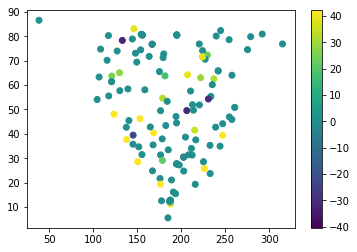

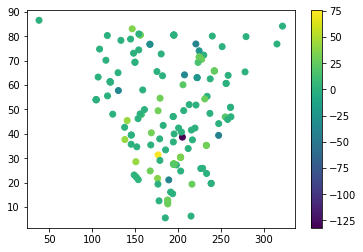

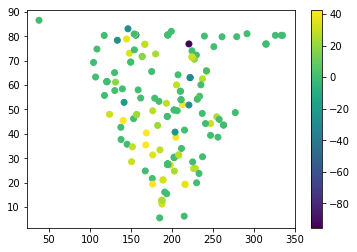

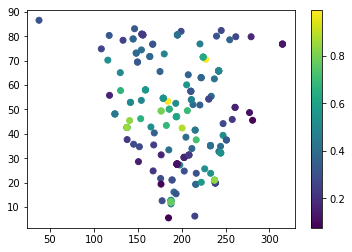

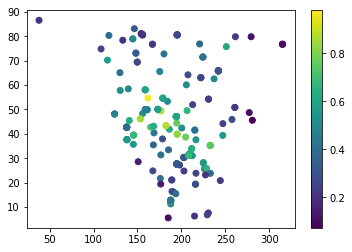

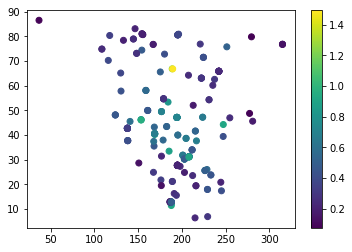

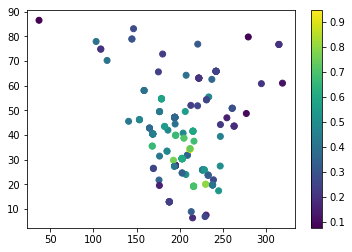

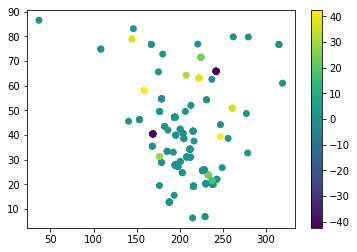

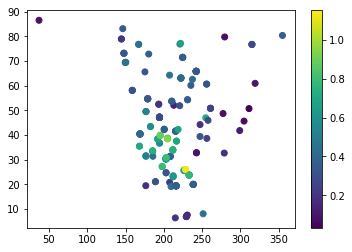

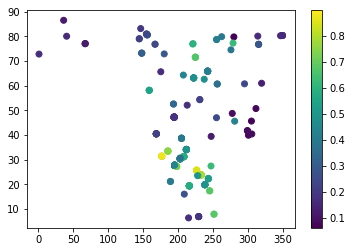

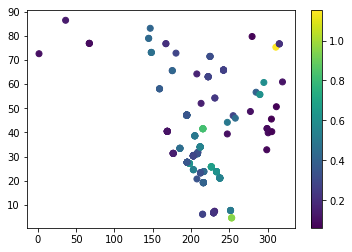

In [5]:

for frame in np.unique(tot_df.frame):
    plt.figure(frame)
    
    plt.scatter(tot_df[tot_df.frame == frame].ra,
                tot_df[tot_df.frame == frame].decl,
                c = tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg)
    plt.colorbar()

In [118]:
# times = [('01:30:00','01:45:00'),
#                      ('01:45:00','02:00:00'),
#                      ('02:00:00','02:15:00'),
#                      ('02:30:00','02:45:00'),
#                      ('02:45:00','03:00:00'),
#                      ('03:00:00','03:15:00'),
#                      ('03:30:00','03:45:00'),
#                      ('03:45:00','04:00:00'),
#                      ('04:00:00','04:15:00'),
#                      ('04:30:00','04:45:00'),
#                      ('04:45:00','05:00:00')]
    
    
# times[frame][0]

pd.date_range(start='2017-02-27 01:30:00', end="2017-02-27 05:00:00",  freq="120s")

DatetimeIndex(['2017-02-27 01:30:00', '2017-02-27 01:32:00',
               '2017-02-27 01:34:00', '2017-02-27 01:36:00',
               '2017-02-27 01:38:00', '2017-02-27 01:40:00',
               '2017-02-27 01:42:00', '2017-02-27 01:44:00',
               '2017-02-27 01:46:00', '2017-02-27 01:48:00',
               ...
               '2017-02-27 04:42:00', '2017-02-27 04:44:00',
               '2017-02-27 04:46:00', '2017-02-27 04:48:00',
               '2017-02-27 04:50:00', '2017-02-27 04:52:00',
               '2017-02-27 04:54:00', '2017-02-27 04:56:00',
               '2017-02-27 04:58:00', '2017-02-27 05:00:00'],
              dtype='datetime64[ns]', length=106, freq='120S')

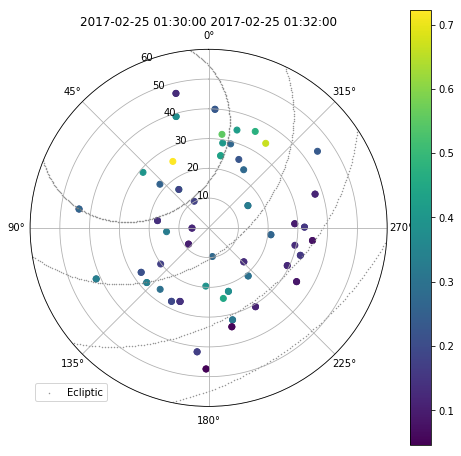

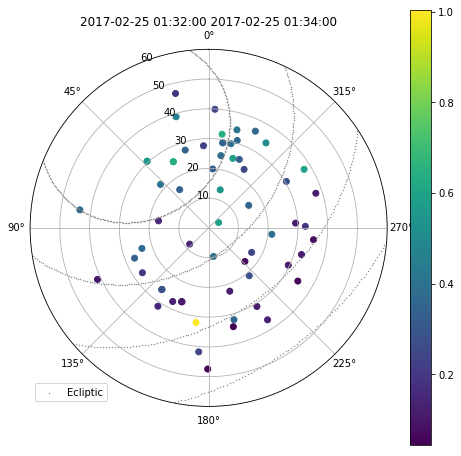

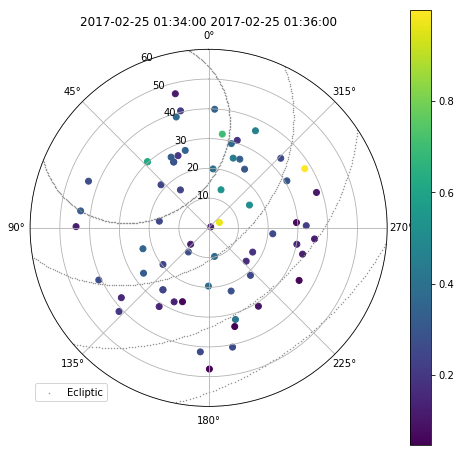

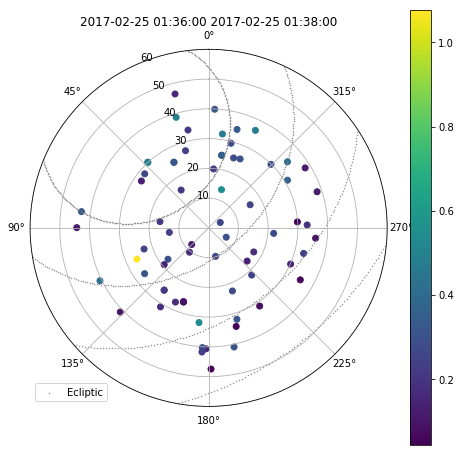

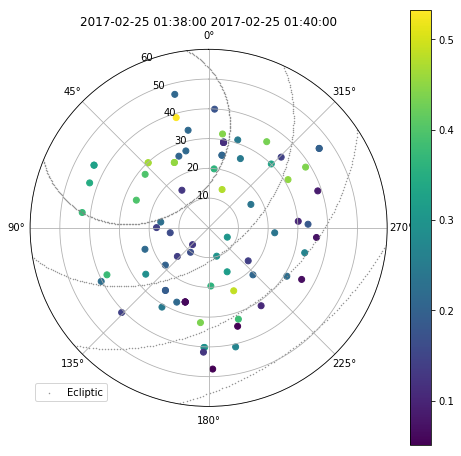

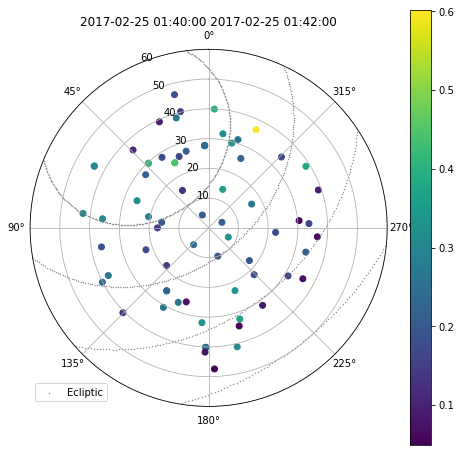

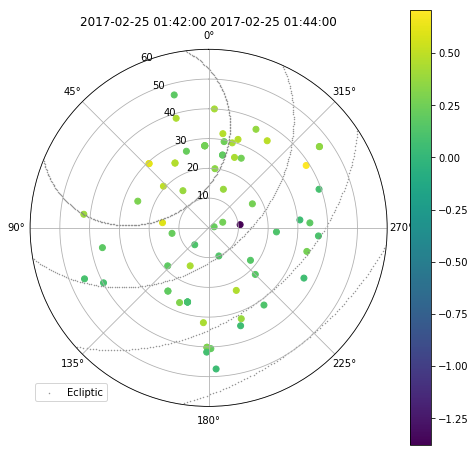

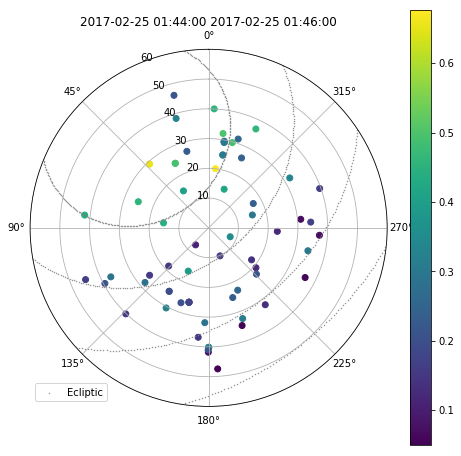

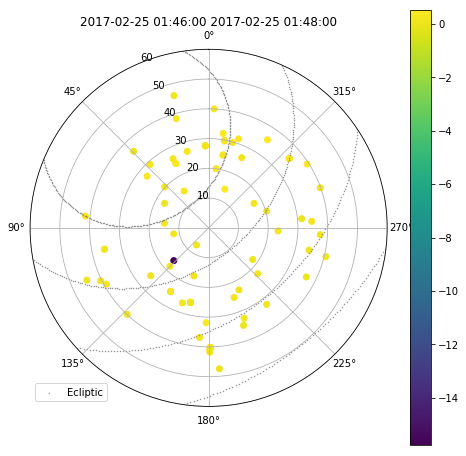

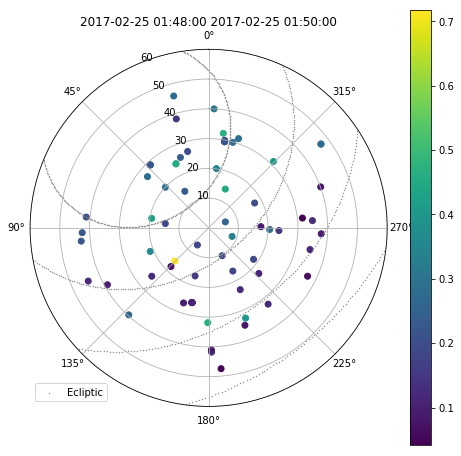

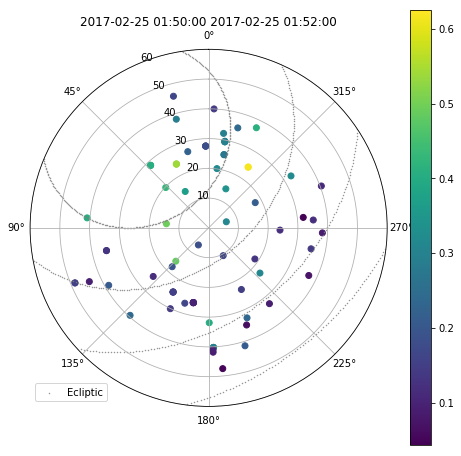

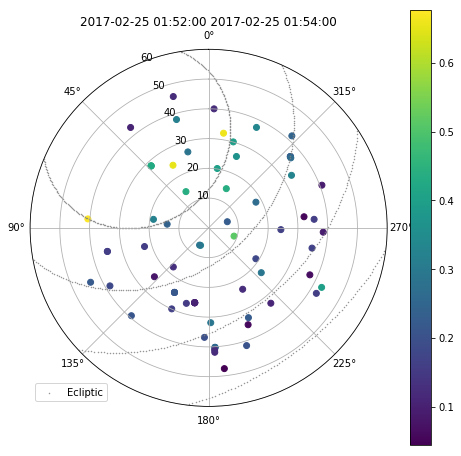

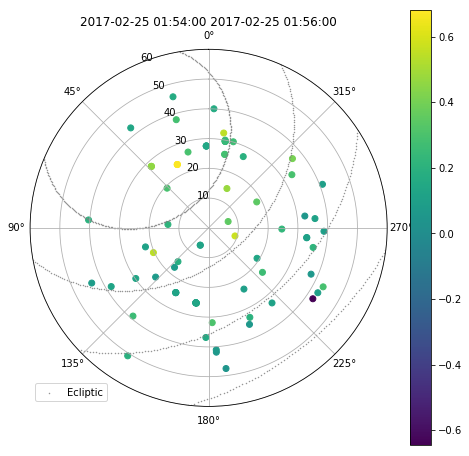

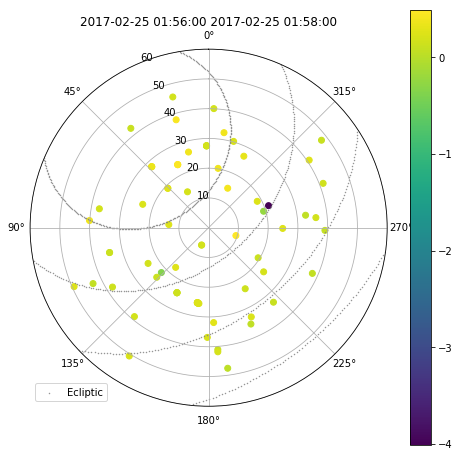

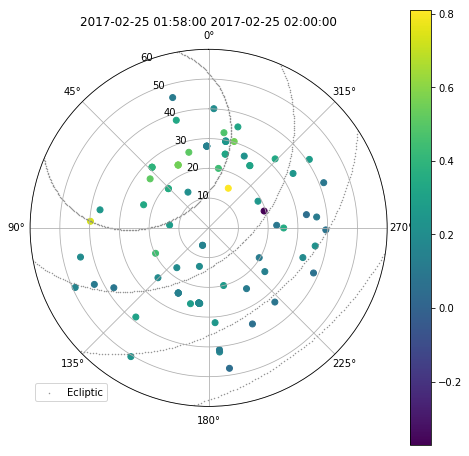

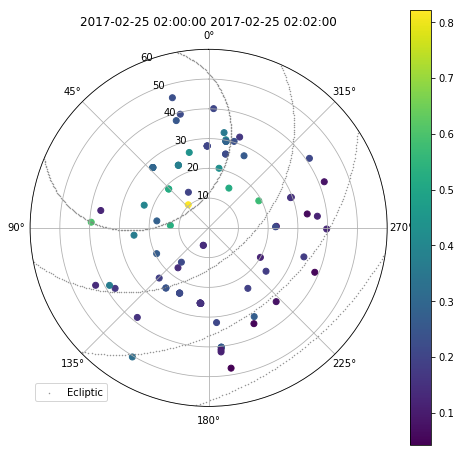

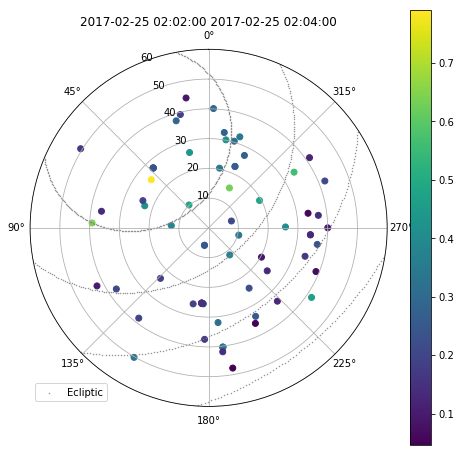

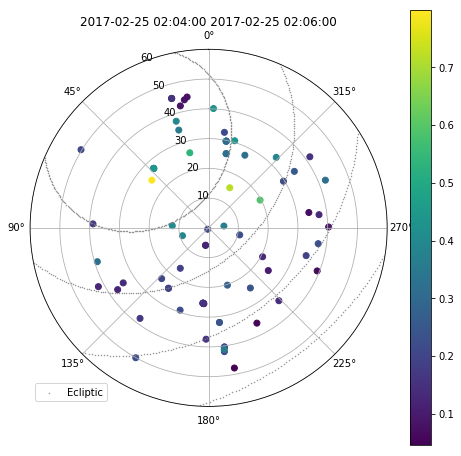

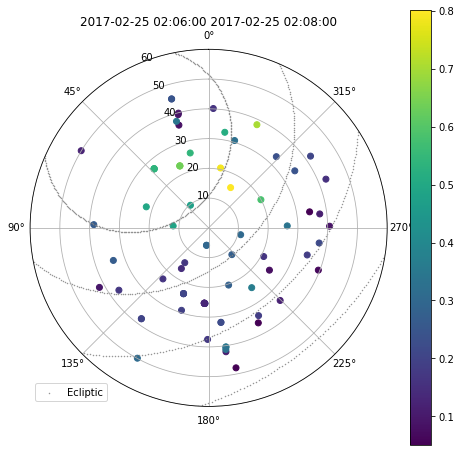

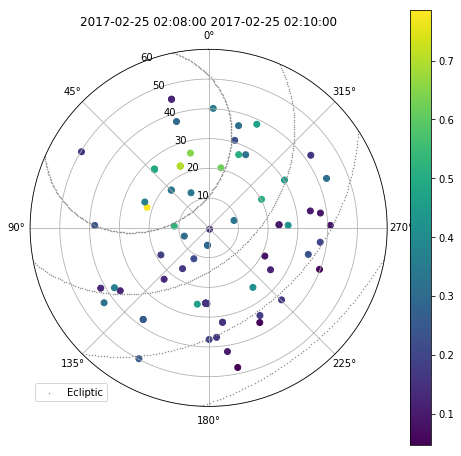

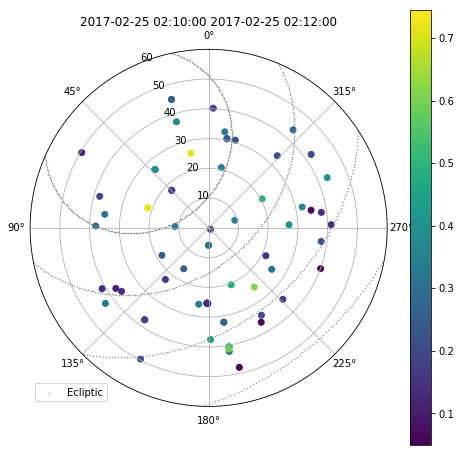

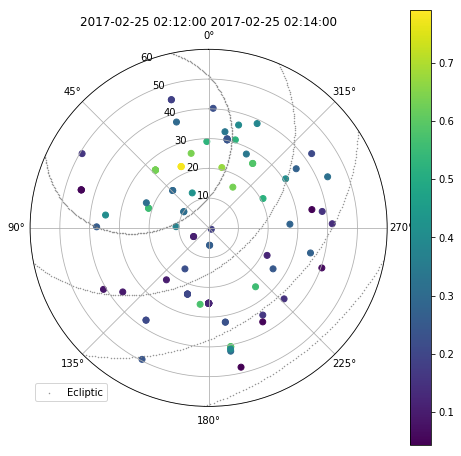

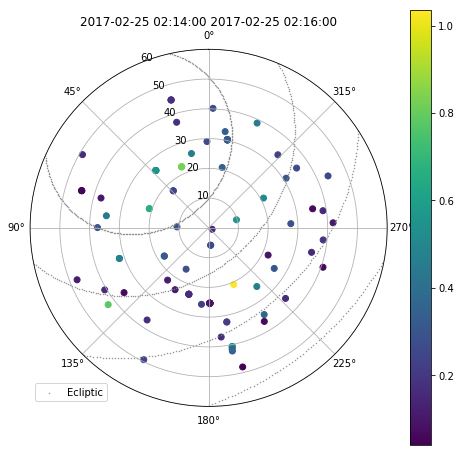

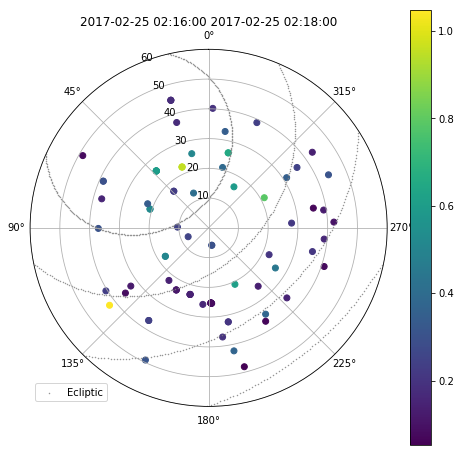

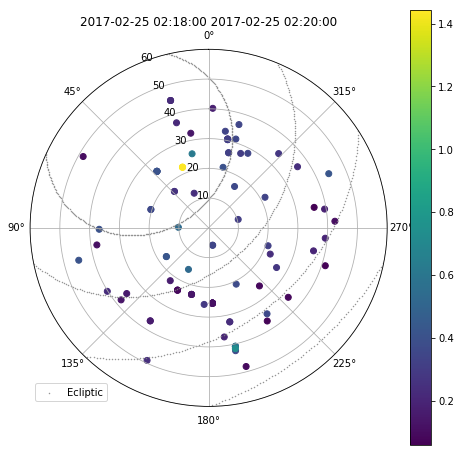

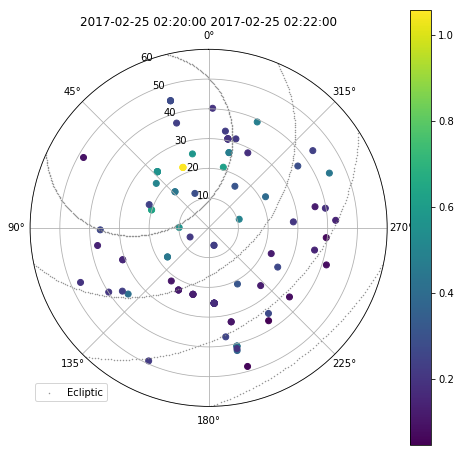

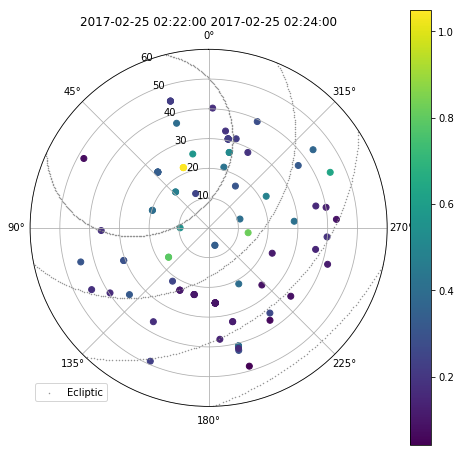

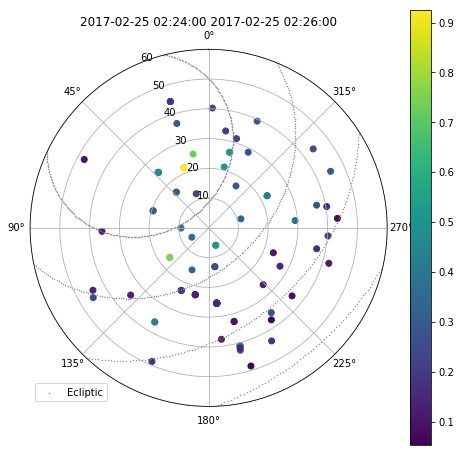

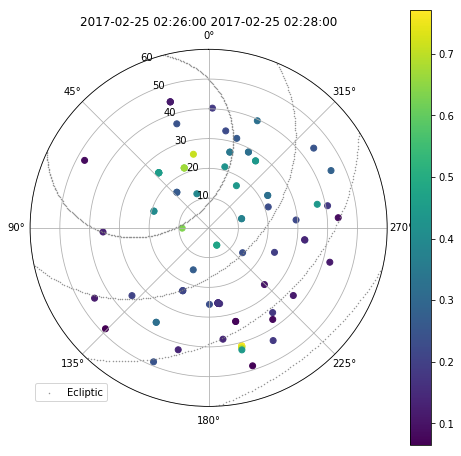

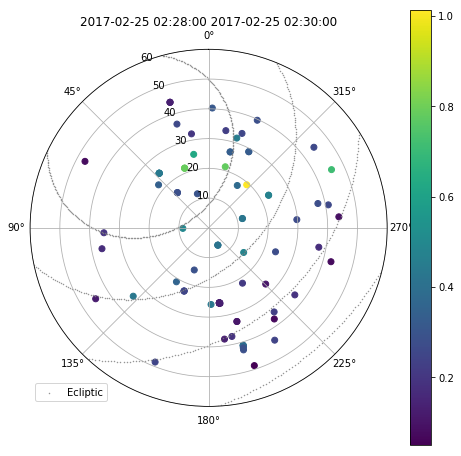

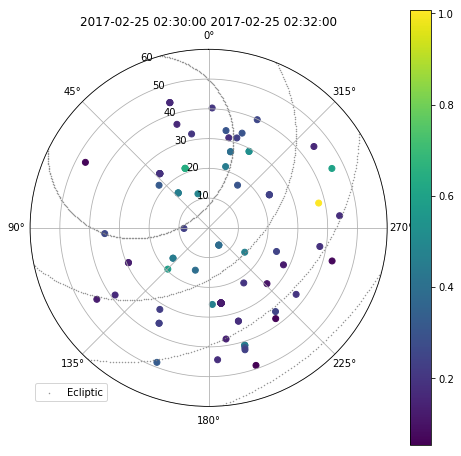

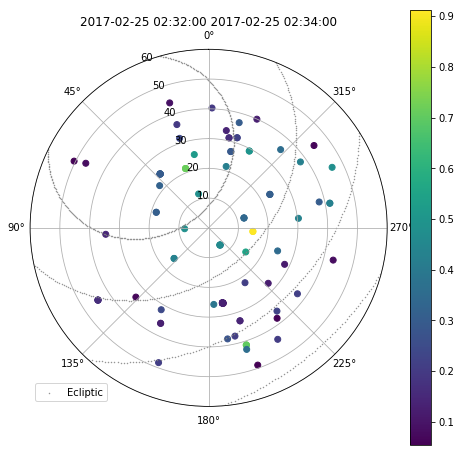

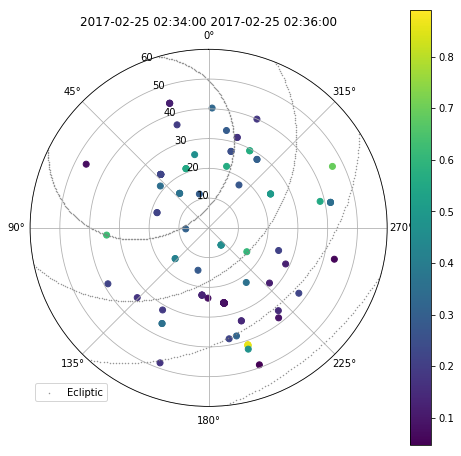

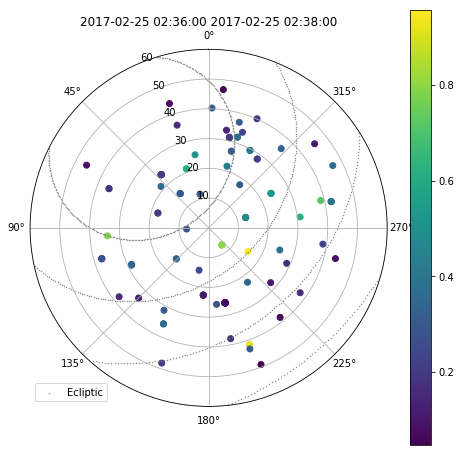

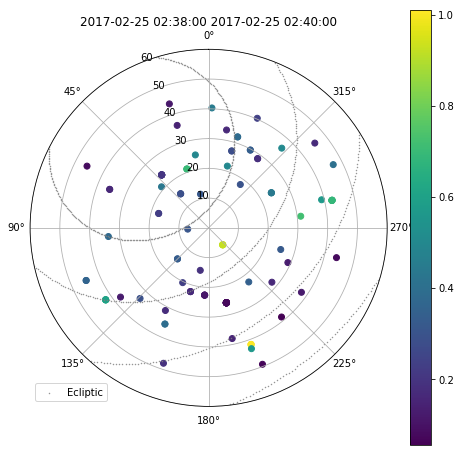

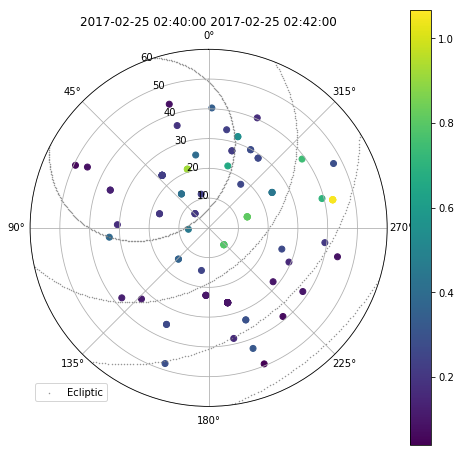

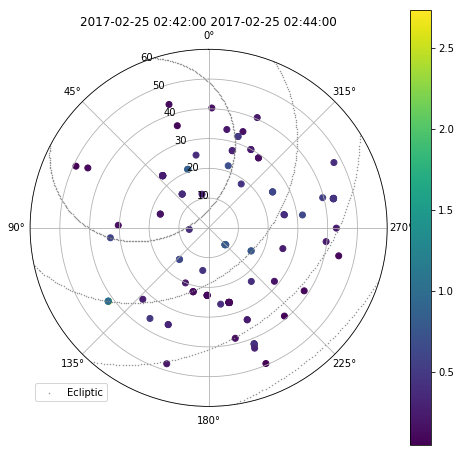

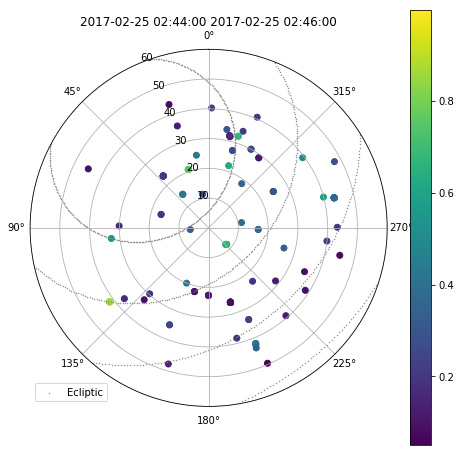

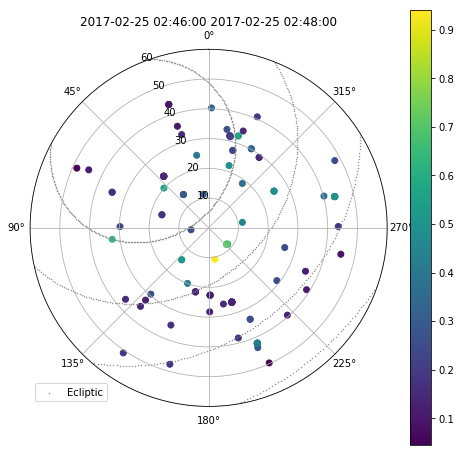

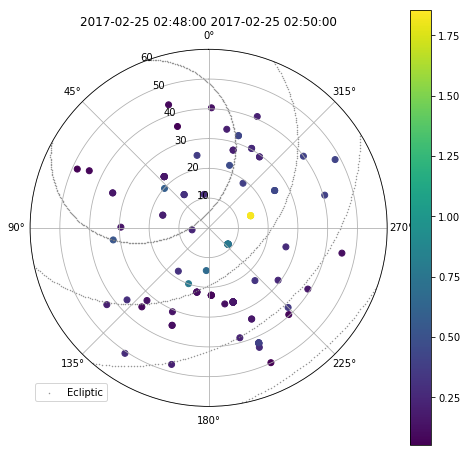

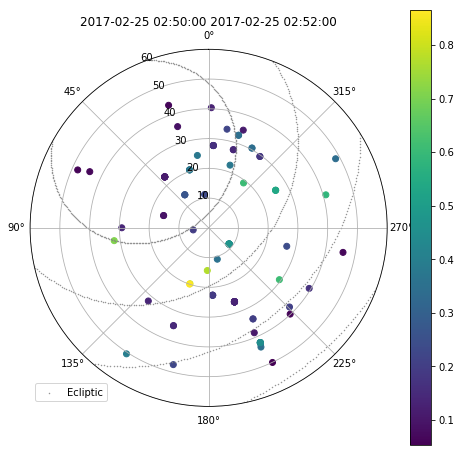

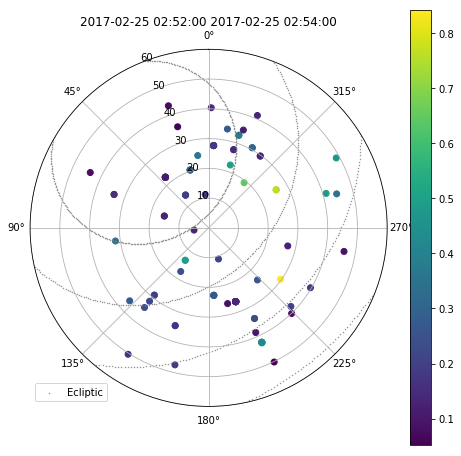

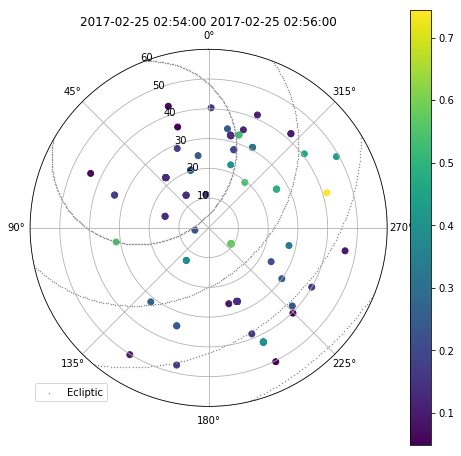

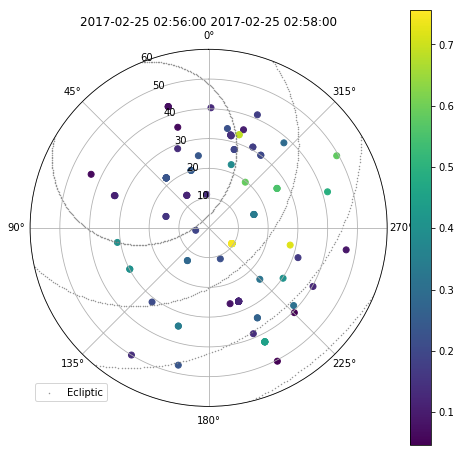

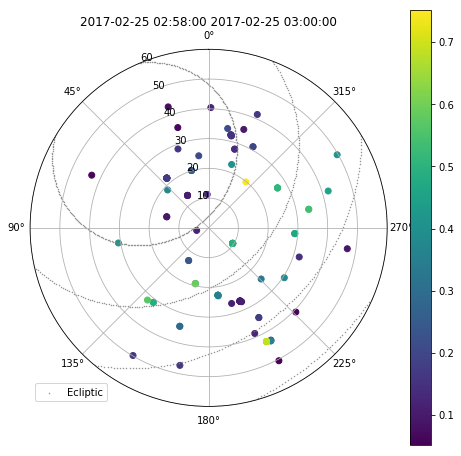

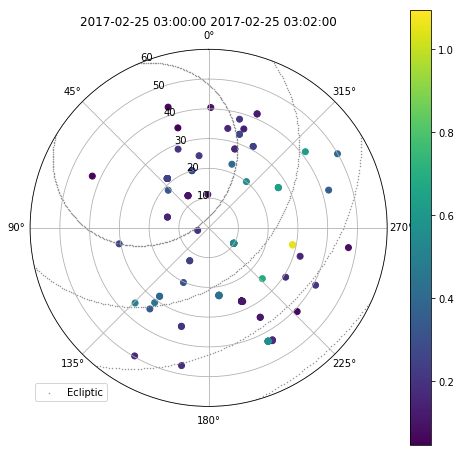

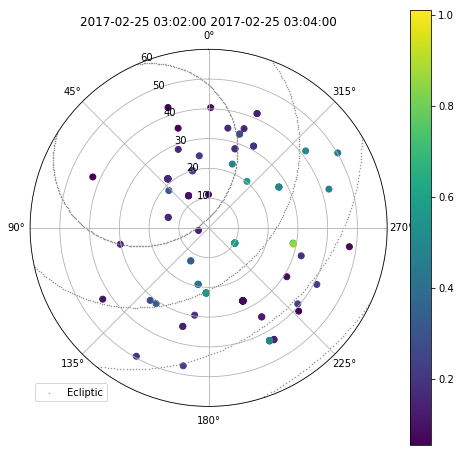

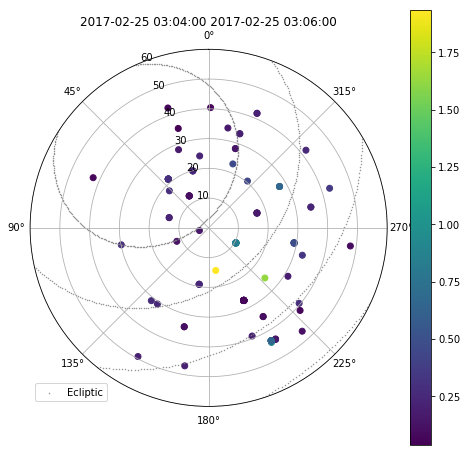

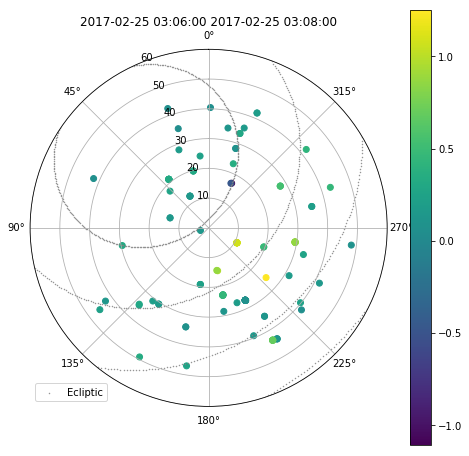

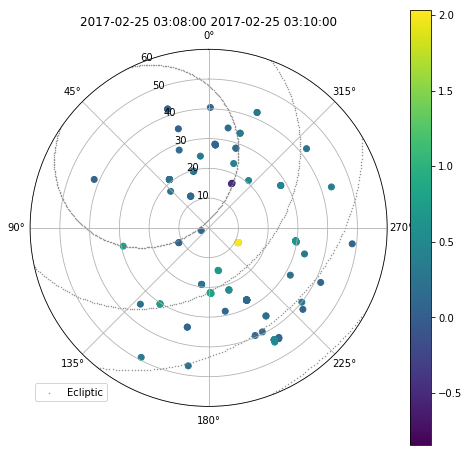

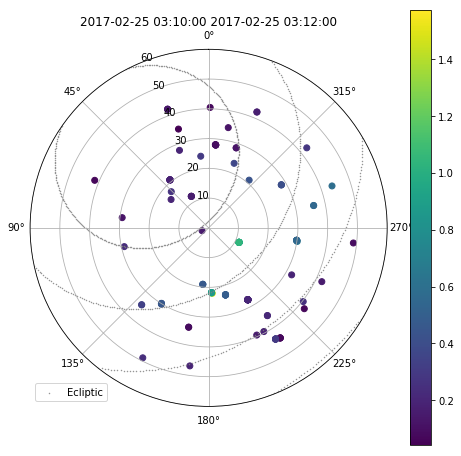

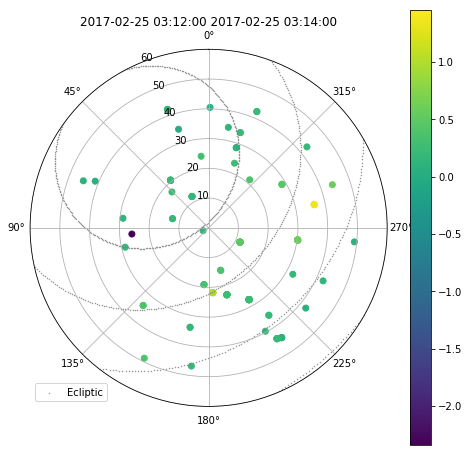

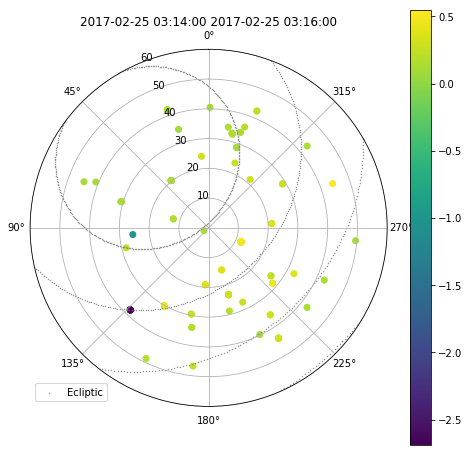

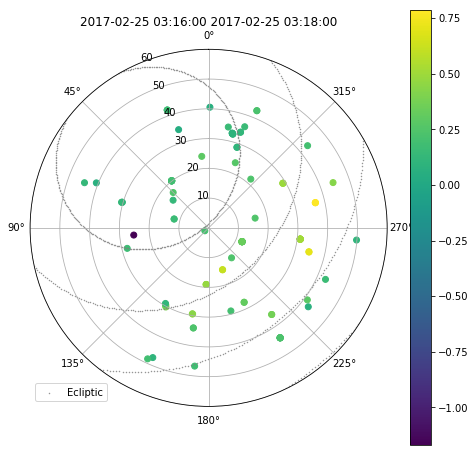

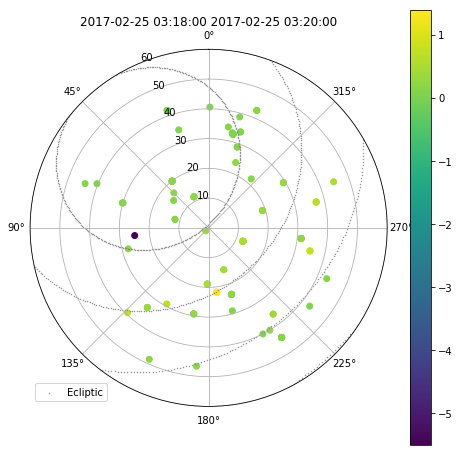

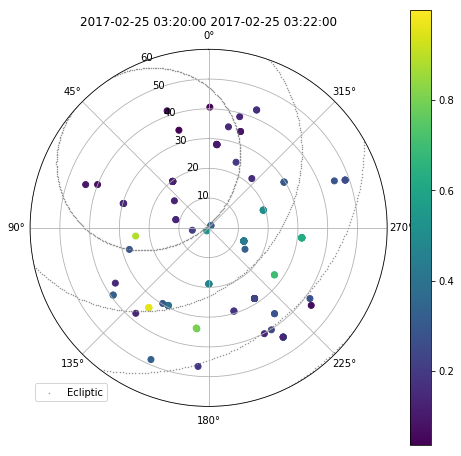

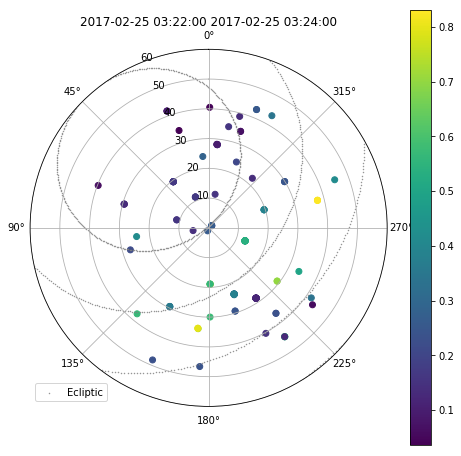

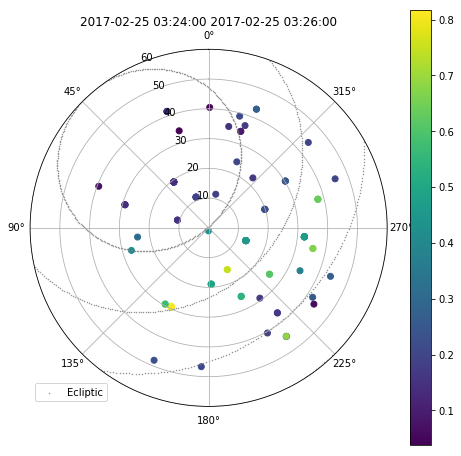

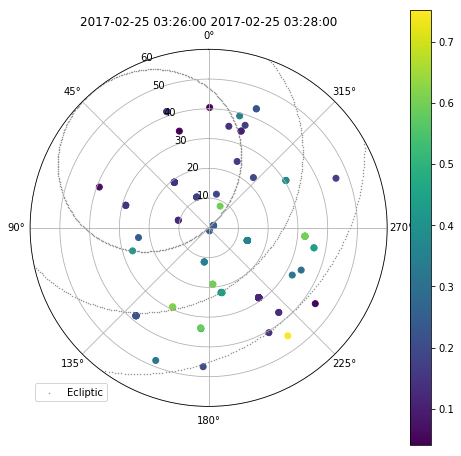

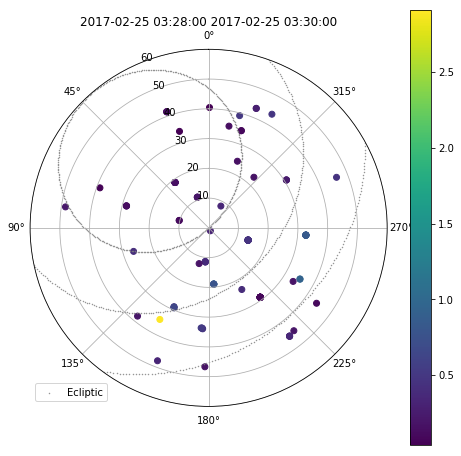

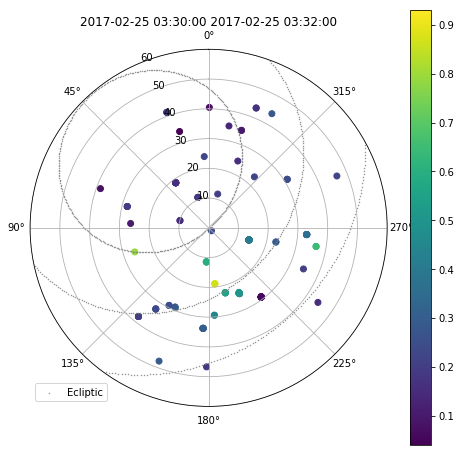

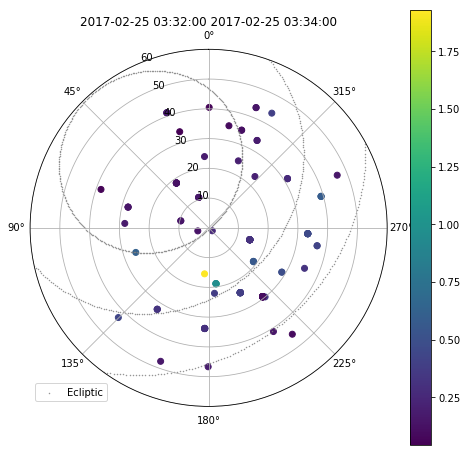

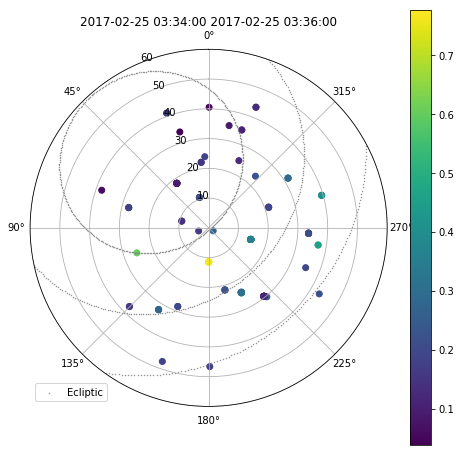

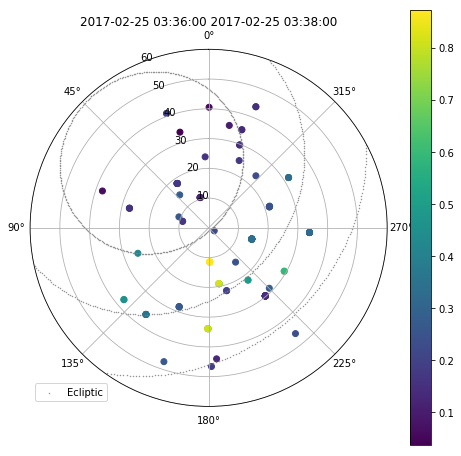

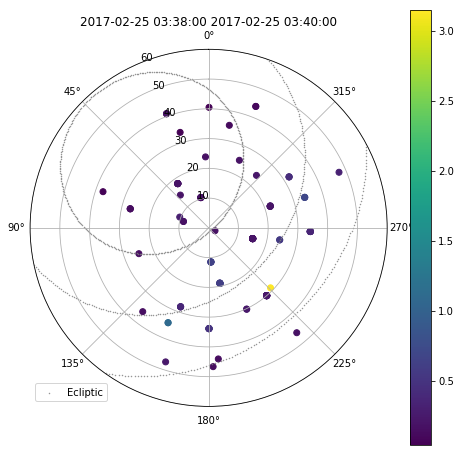

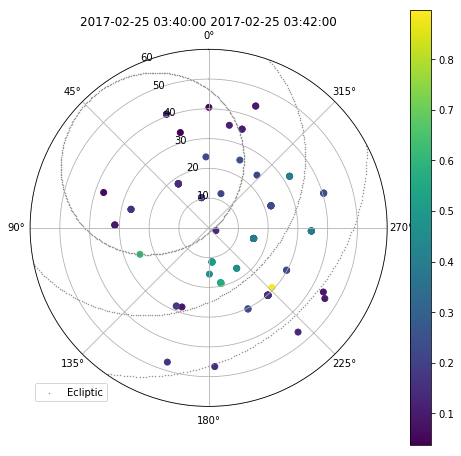

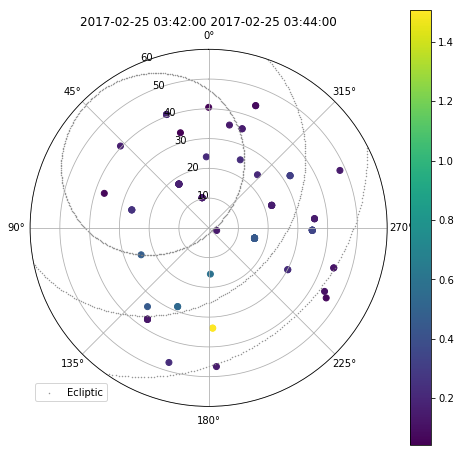

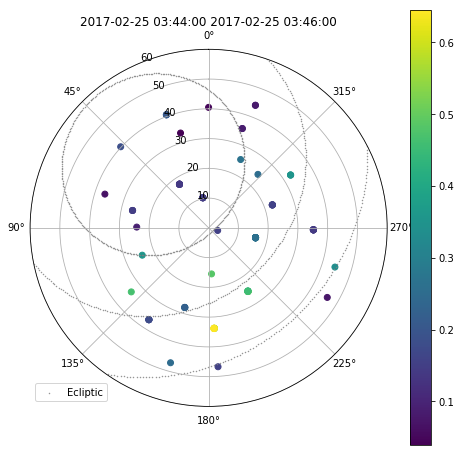

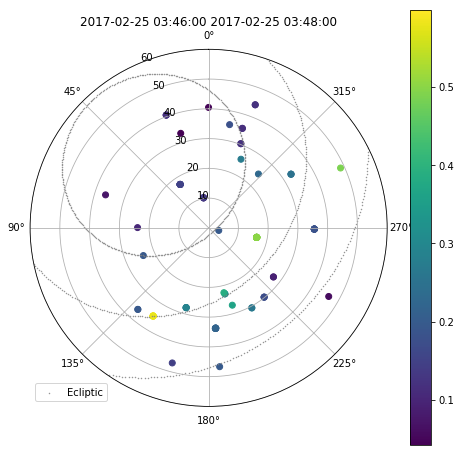

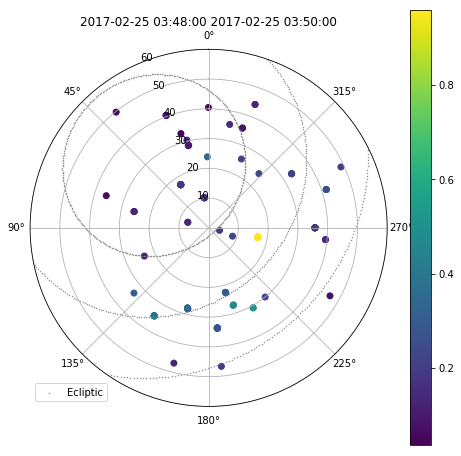

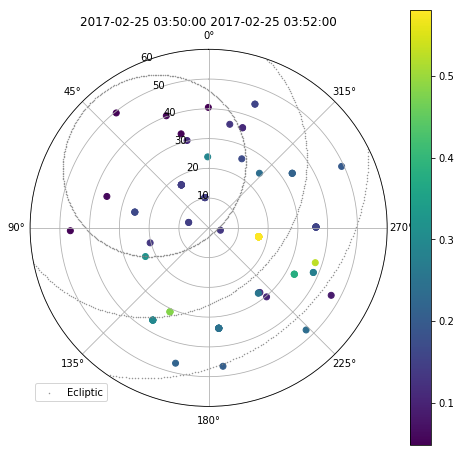

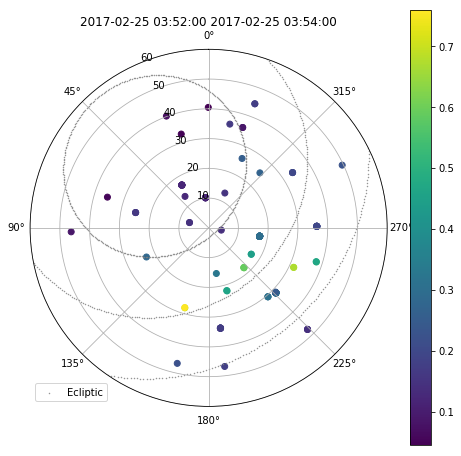

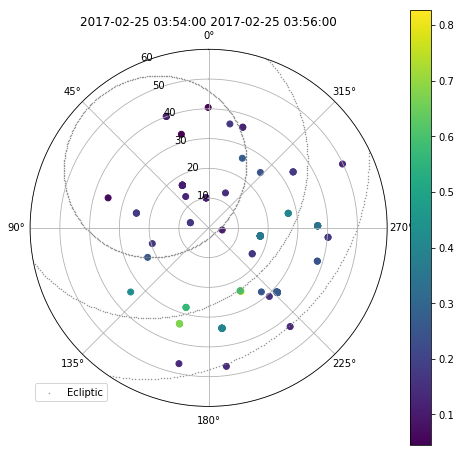

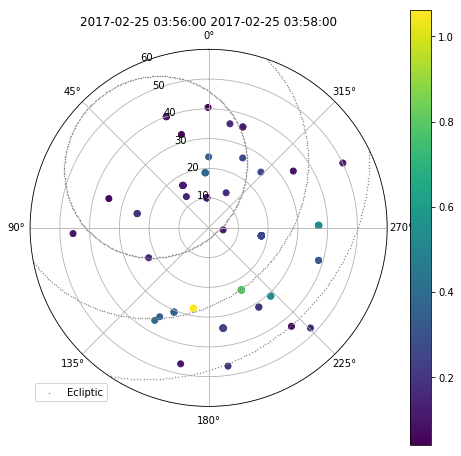

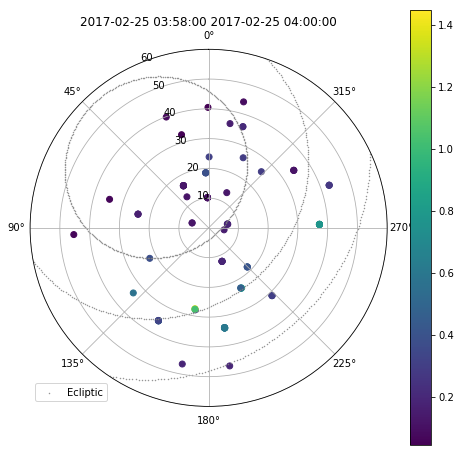

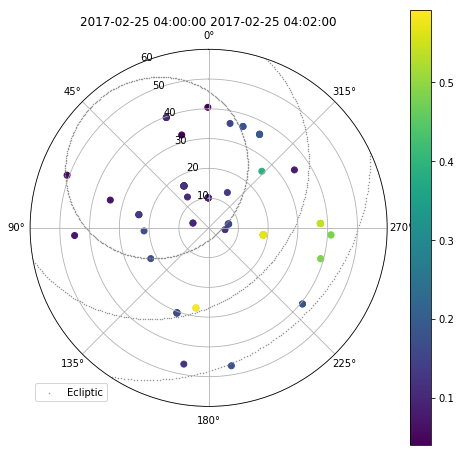

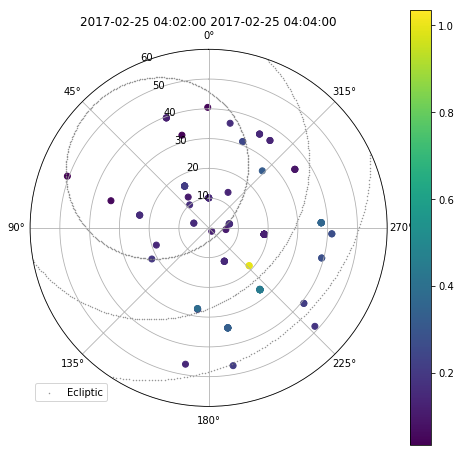

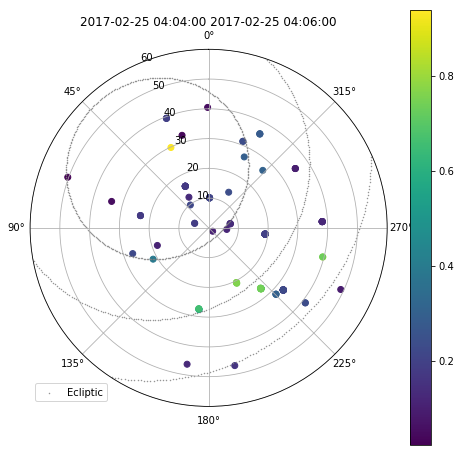

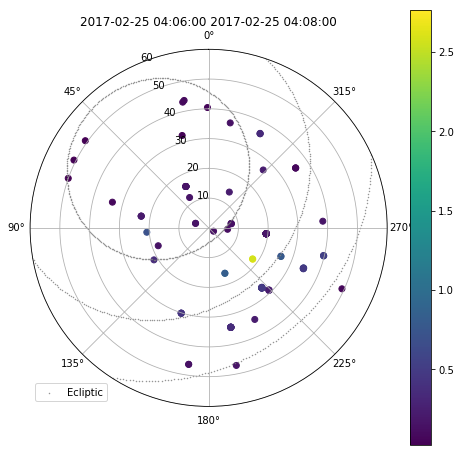

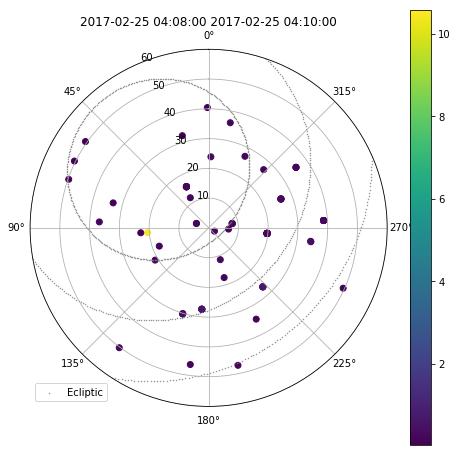

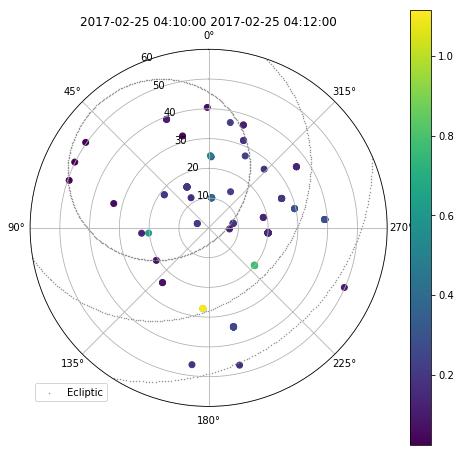

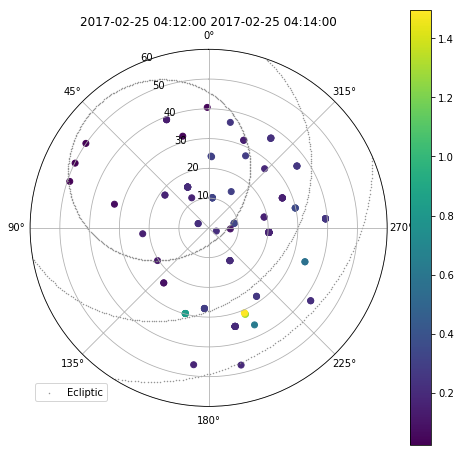

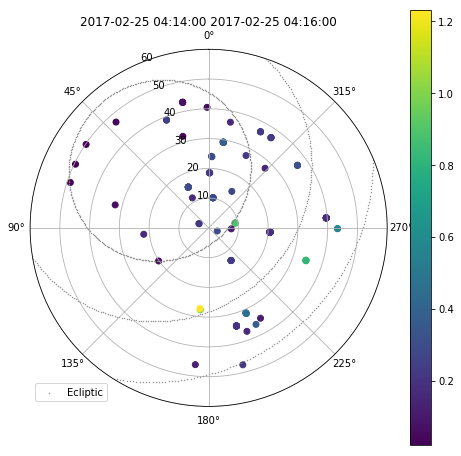

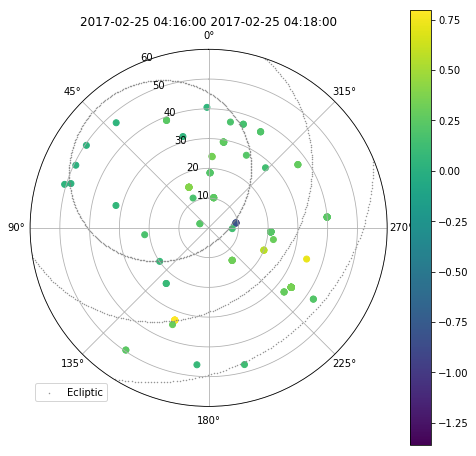

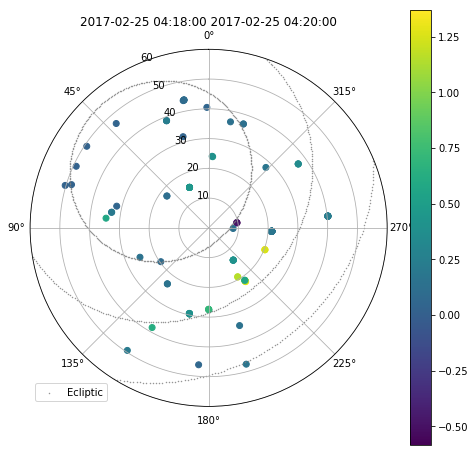

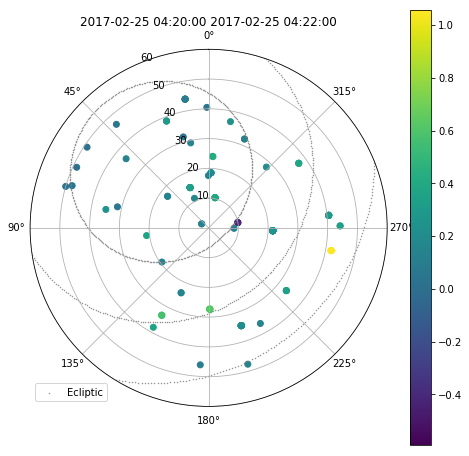

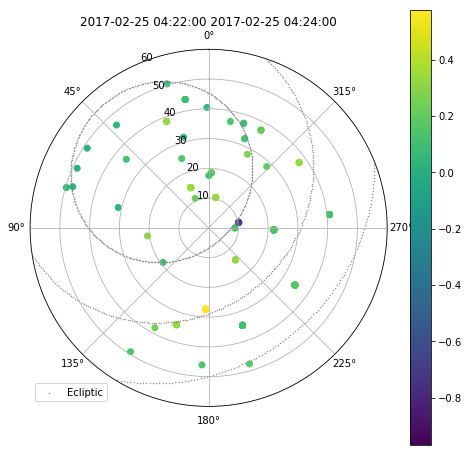

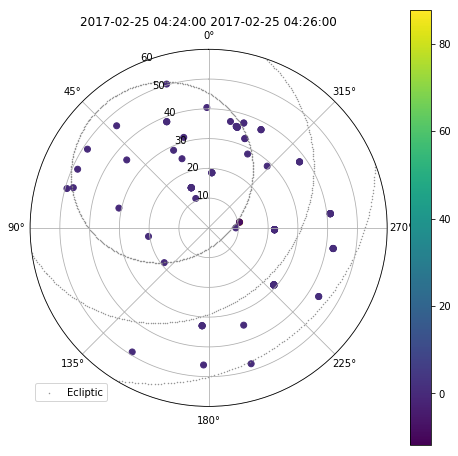

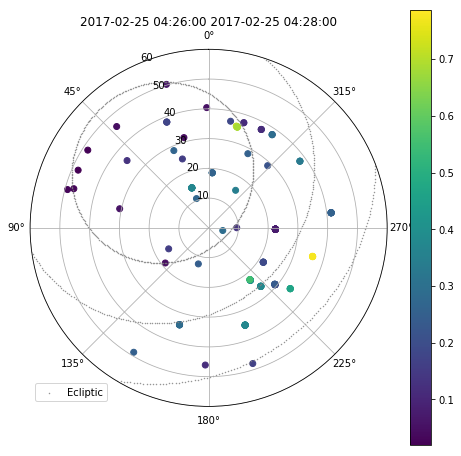

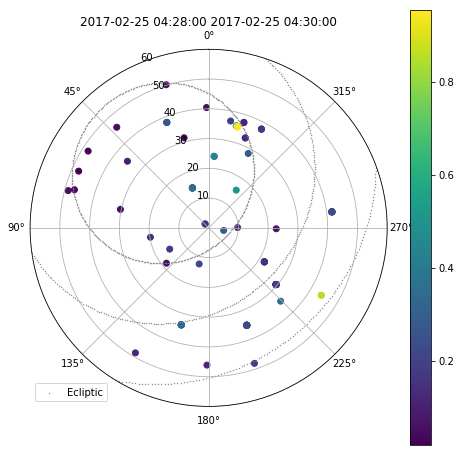

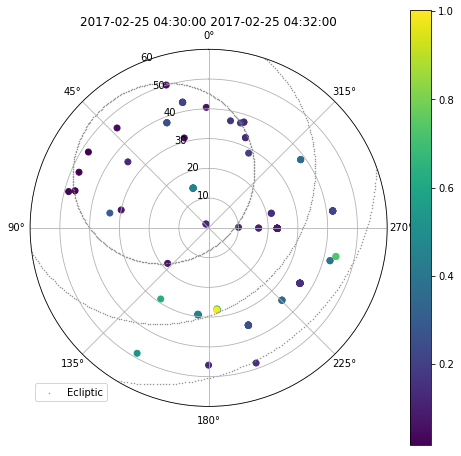

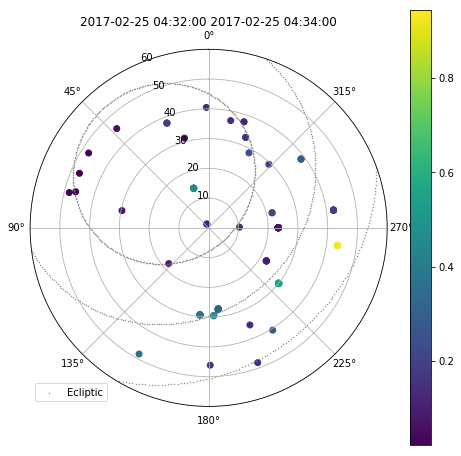

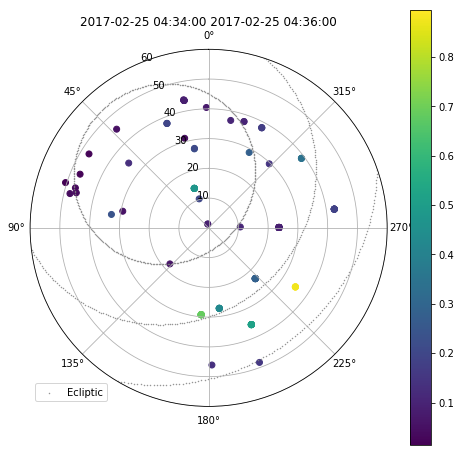

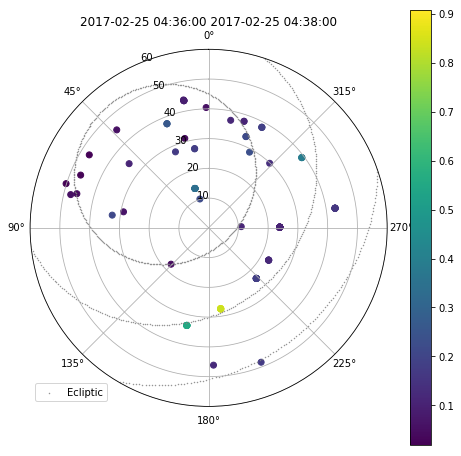

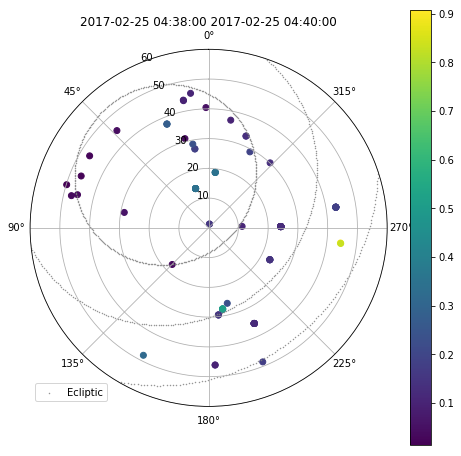

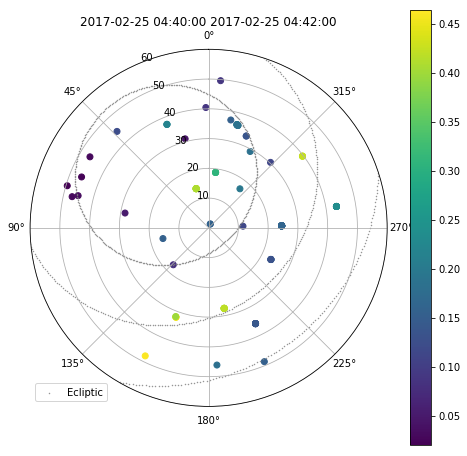

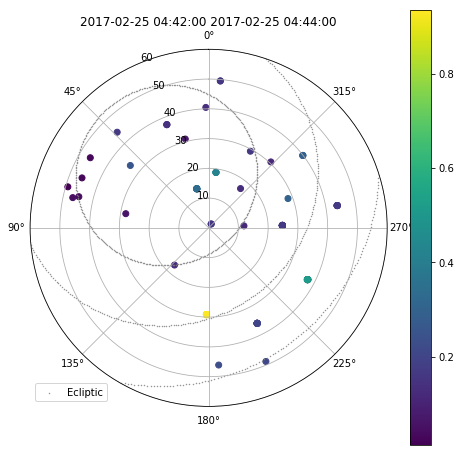

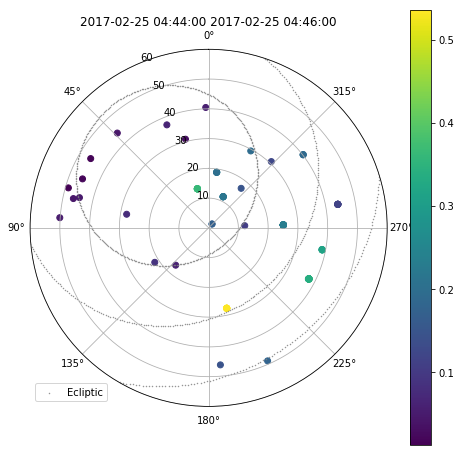

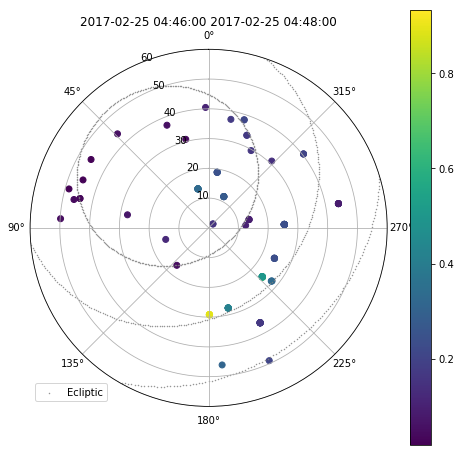

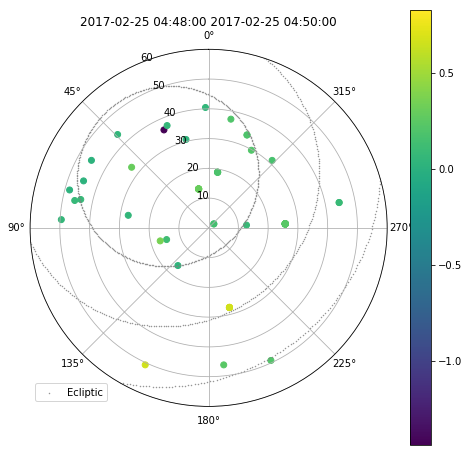

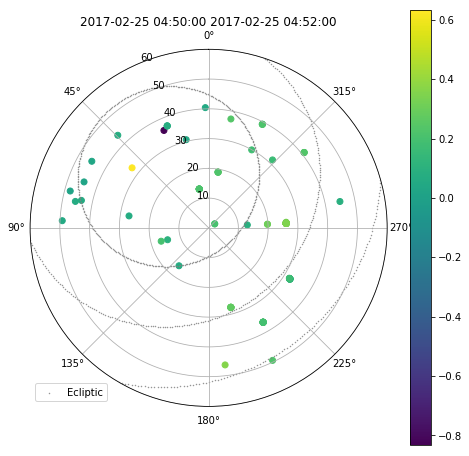

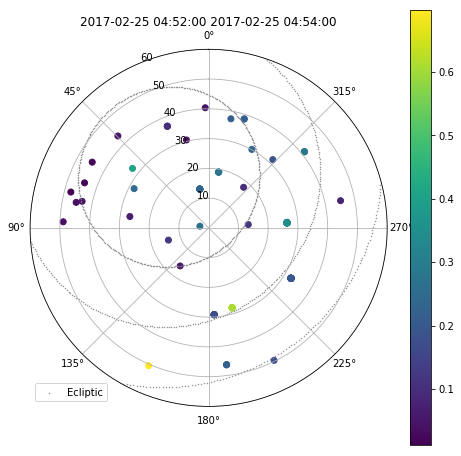

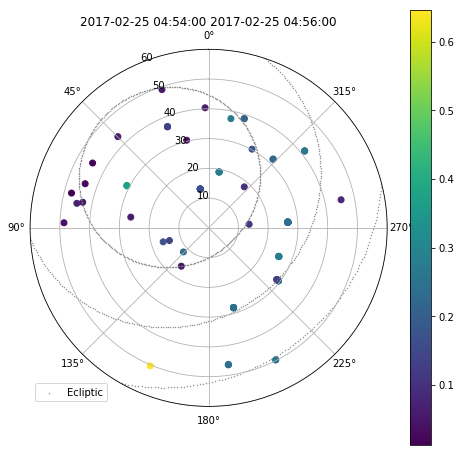

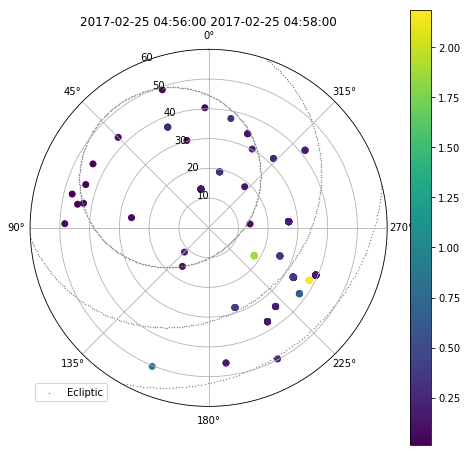

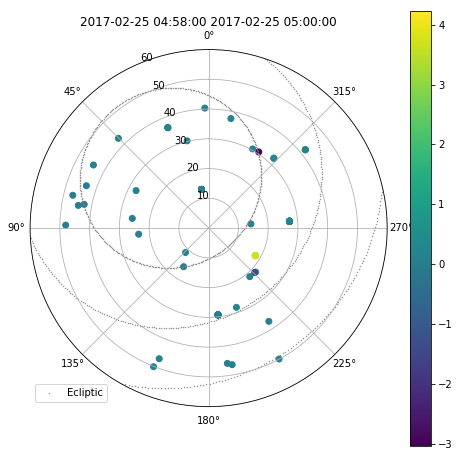

In [31]:
CS002 = EarthLocation.from_geocentric (3826577.109500000, 461022.900196000, 5064892.758, 'm')

times =  pd.date_range(start='2017-02-25 01:30:00', end="2017-02-25 05:00:00",  freq="120s")

tot_df = tot_df.groupby("ra").mean().reset_index()
n=0
for frame in np.unique(tot_df.frame):

    list_ra = [x*u.degree for x in tot_df[tot_df.frame == frame].ra]
    list_decl = [x*u.degree for x in tot_df[tot_df.frame == frame].decl]

    position = SkyCoord(list_ra, list_decl)


    obs_times = [times[int(frame)]] 


    altaz = position.transform_to(AltAz(obstime=obs_times* len(list_ra), location=CS002))
    ecliptic = SkyCoord(np.concatenate([np.linspace(0,360,360),
                                   np.linspace(0,360,360),
                                   np.linspace(0,360,360),
                                   np.linspace(0,360,360) ]), 
                        np.concatenate([np.zeros(360),
                                   20*np.ones(360),
                                   40*np.ones(360),
                                   60*np.ones(360)]), 
                        unit="deg", 
                        frame='barycentrictrueecliptic').transform_to(AltAz(obstime=obs_times* 4*360, location=CS002))

    
    plt.figure(frame, figsize=(8,8))
    ax = plt.subplot(projection="polar")
    plt.scatter( altaz.az.rad, 
                (90-altaz.alt.deg), 
                c=tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg)

    plt.colorbar()
#     plt.scatter( ecliptic.az.rad,(90-ecliptic.alt.deg), s=1)
    ax.set_theta_zero_location("N")

    plt.scatter(ecliptic.az.rad,(90-ecliptic.alt.deg),c="grey", s=0.2, label="Ecliptic")

#     grid_x, grid_y = np.mgrid[-50:50:100j, -50:50:100j]

#     plt.imshow(griddata(zip(pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0],
#            -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]),
#         tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg,
#         (grid_x, grid_y ), method="linear"), origin="lower" )
    
    plt.title(str(times[int(n)])+" "+str(times[int(n)+1]))
    plt.legend(loc="lower left")
#     plt.xlim([0,110])
    plt.ylim([0,60])
    plt.savefig("/home/kuiack/modindex/{}.png".format(str(n).zfill(3)))
    plt.show()
plt.figr    n+=1

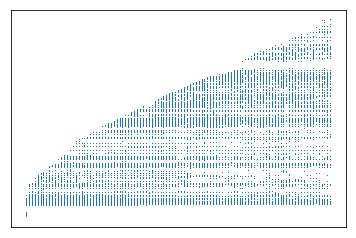

In [37]:
plt.xticks([]);plt.yticks([])
plt.plot(tot_df.frame,tot_df.runcat, ",")

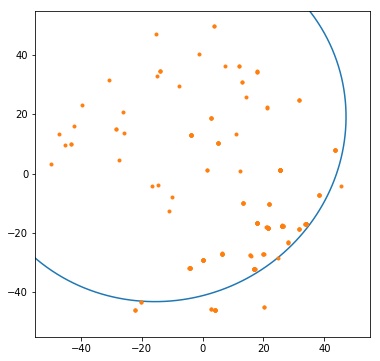

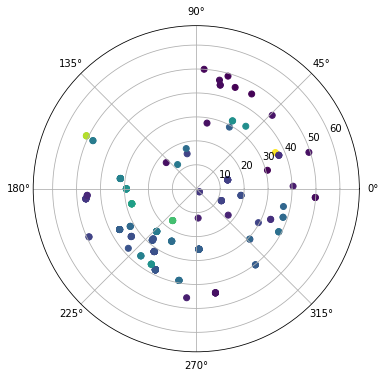

In [98]:
plt.figure(figsize=(6,6))

plt.plot(-pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[1],
       pol2cart((90-ecliptic.alt.deg), ecliptic.az.rad,)[0])

plt.plot(pol2cart(-(90-altaz.alt.deg), altaz.az.rad,)[1],
           pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0], ".")
plt.xlim([-55,55])
plt.ylim([-55,55])


plt.figure(frame, figsize=(6,6))
ax = plt.subplot(projection="polar")
plt.scatter( altaz.az.rad,(90-altaz.alt.deg) ,c=tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg)




# ax.set_theta_zero_location("N")

In [38]:



from scipy.interpolate import Rbf

x = -pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1]
y = pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0]

z = tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg


rbfi = Rbf(x,y,z, epsilon=2)
plt.imshow(rbfi(grid_x, grid_y))


/afhome/kuiack/newtrap/local/lib/python2.7/site-packages/scipy/interpolate/rbf.py:220: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.869009e-21
  self.nodes = linalg.solve(self.A, self.di)


NameError: name 'grid_x' is not defined

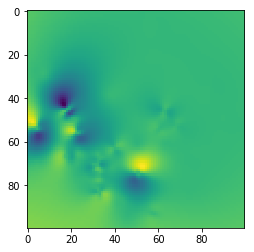

TypeError: Input z must be a 2D array.

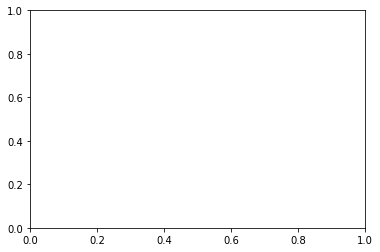

In [21]:
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib import pyplot as pp

# kernel density estimate of the PDF
kde = gaussian_kde(points)

# evaluate the estimated PDF on a grid
x,y = np.mgrid[40:101,-20:101]
z = kde((x.ravel(),y.ravel())).reshape(*x.shape)

# plot
fig,ax = pp.subplots(1,1)
ax.hold(True)
pc = ax.pcolor(x,y,z)
cb = pp.colorbar(pc)
cb.ax.set_ylabel('Probability density')
ax.plot(points[0],points[1],'o',mfc='w',mec='k')

pp.show()

In [20]:
from scipy.interpolate import Rbf
x, y, z, d = np.random.rand(4, 50)
rbfi = Rbf(x, y, z, d)  # radial basis function interpolator instance
xi = yi = zi = np.linspace(0, 1, 20)
di = rbfi(xi, yi, zi)   # interpolated values
di

array([ 0.39945272,  0.31784025,  0.26831797,  0.26253208,  0.30194697,
        0.38630496,  0.49998022,  0.5787986 ,  0.5749488 ,  0.55123067,
        0.62579546,  0.80333292,  0.943337  ,  0.91059554,  0.7226246 ,
        0.53134228,  0.44949034,  0.44231203,  0.43369643,  0.40557339])

In [48]:
tot_df.groupby("ra").mean().reset_index()

ra       decl      f_avg      f_std  frame  runcat
0       1.277813  72.752417  32.495889   5.500668    9.0  2303.0
1       1.474913  72.593942  29.498290   3.219502   10.0  2303.0
2      36.190534  86.427415  28.348781   3.981841   10.0   186.0
3      36.498832  86.460234  30.166763   3.696197    9.0   186.0
4      36.701270  86.497203  32.923523   3.010416    5.0   186.0
5      36.757217  86.525033  32.276096   2.334746    7.0   186.0
6      36.855405  86.515476  32.324998   2.480397    6.0   186.0
7      36.967198  86.519618  29.815921   2.706066    8.0   186.0
8      37.504488  86.537809  35.348389  10.999523    3.0   186.0
9      37.874164  86.541624  33.106410   6.766020    4.0   186.0
10     37.934229  86.529741  35.271743  10.128139    2.0   186.0
11     38.076645  86.540347  33.237449  10.390577    1.0   186.0
12     38.593557  86.539149  36.737462  12.923271    0.0   186.0
13     40.763159  79.997629  22.446319   3.656440    9.0  2478.0
14     67.147890  76.881014  24.152490   2.291981   10.0  1704.5
15     67.148567  76.881400  24.155099   2.292264   10.0   230.0
16     67.233841  76.981965  21.188753   2.700077    9.0  2497.0
17     67.251576  76.985868  21.136219   2.748602    9.0   912.0
18     67.254196  76.986665  21.125604   2.744822    9.0   230.0
19    103.093622  77.905641  13.563323   5.408668    6.0   228.0
20    104.448008  69.262859  17.145963   4.284403    2.0   211.0
21    104.576717  53.993732  34.479332  12.811160    1.0   395.5
22    104.578068  53.993412  34.480757  12.800634    1.0   541.0
23    104.610486  54.015724  33.046050  10.981704    1.0   713.0
24    104.630809  54.084593  28.923359   9.811608    0.0   209.0
25    106.847505  63.300637  17.365638  11.642016    0.0   168.0
26    106.879828  63.282378  16.740860   5.241159    1.0   168.0
27    106.898004  63.291083  13.921556   4.977512    2.0   168.0
28    108.486763  74.848498  16.644760   4.078391    7.0  1574.0
29    108.488008  74.830228  19.295834   4.086129    6.0  1574.0
...          ...        ...        ...        ...    ...     ...
2113  315.065076  76.717139  16.218744   4.616950    8.0   715.0
2114  315.070096  76.729016  16.217462   4.618003    8.0   196.0
2115  315.077625  76.838503  32.024791   6.654183    0.0   196.0
2116  315.093449  76.716236  20.534039   4.207152    6.0   682.0
2117  315.094483  76.715550  20.536678   4.204422    6.0   715.0
2118  315.101319  76.722820  20.518712   4.222863    6.0   196.0
2119  315.144167  76.699405  19.576590   5.502179    7.0   682.0
2120  315.145226  76.698769  19.570869   5.507694    7.0   715.0
2121  315.149275  76.705476  19.657791   5.388842    7.0   196.0
2122  315.150971  76.667507  22.938590   5.024783   10.0   682.0
2123  315.151532  76.667214  22.932319   5.041811   10.0   715.0
2124  315.151605  76.670336  22.980041   4.927937   10.0   196.0
2125  315.168803  76.724753  27.320613   2.948946    4.0   682.0
2126  315.168853  76.724709  27.320613   2.948946    4.0   715.0
2127  315.169706  76.725164  27.321717   2.946733    4.0   196.0
2128  319.243568  61.002741  32.161143   2.983032    7.0  1927.0
2129  319.259525  61.008575  34.264320   3.951552    6.0  1927.0
2130  319.260004  60.928184  30.652679   3.131368    8.0  1927.0
2131  319.283655  60.923247  33.543348   3.967015   10.0  1927.0
2132  319.345815  60.923826  31.401660   4.213874    9.0  1927.0
2133  321.388534  84.150015  16.212228   4.450748    1.0   309.0
2134  326.104792  80.372977  21.578306   2.150344    2.0  1039.0
2135  333.381144  80.367168  21.520143   2.052085    2.0   507.0
2136  334.822388  80.368729  21.506900   2.046491    2.0   308.0
2137  346.425967  80.202954  22.142882   3.568784    9.0  1520.0
2138  348.750675  80.275663  22.043805   3.601128    9.0  1056.0
2139  349.165087  80.283910  22.020332   3.609867    9.0  1039.0
2140  349.169945  80.292733  22.014859   3.636515    9.0   308.0
2141  349.180973  80.290385  22.022786   3.635889    9.0   507.0
2142  354.998908  80.363511  21.405974   7.689766

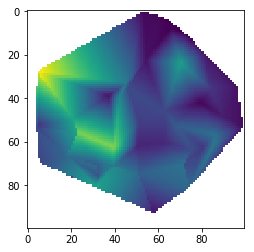

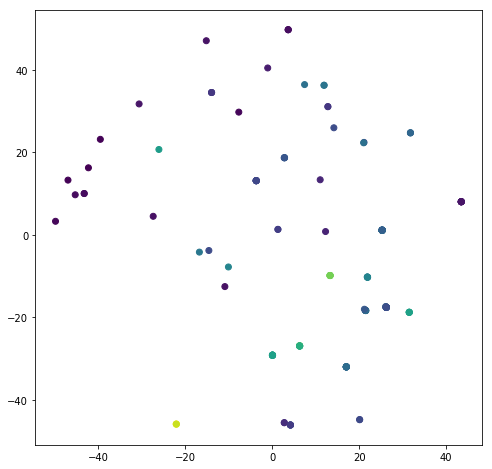

In [94]:
plt.figure(figsize=(8,8))
plt.scatter(-pol2cart((90-altaz.alt.deg), altaz.az.rad,)[1],
           pol2cart((90-altaz.alt.deg), altaz.az.rad,)[0],
           c=tot_df[tot_df.frame == frame].f_std/tot_df[tot_df.frame == frame].f_avg)